In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.12.0


In [3]:
# Set parameters here 
INPUT_SIZE = 256
BATCH_SIZE = 64

SEED = 12345
np.random.seed(SEED)

path = '../data/caltech-101/101_ObjectCategories'
classes = os.listdir(path)
myclasses = classes
myclasses.remove('BACKGROUND_Google')
myclasses.remove('Faces')
myclasses.remove('.DS_Store')

NUMCLASSES = len(myclasses)

mapping = {}
for i in range(NUMCLASSES):
    mapping[i] = myclasses[i]


In [4]:
from skimage import exposure

def preprocess(img):
    if len(img.shape)==2:
        img = np.stack([img, img, img], axis = 2)

    img = img - np.min(img)
    img = img / np.max(img)
    
    img = img - np.mean(img)
    img = img / np.std(img)   
    return img


In [5]:
train_datagen = ImageDataGenerator(
                                featurewise_center=False,
                                samplewise_center=False,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=False,
                                zca_epsilon=1e-06,
                                rotation_range=5,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                brightness_range=None,
                                shear_range=0.5,
                                zoom_range=0.05,
                                channel_shift_range=0.0,
                                fill_mode="nearest",
                                cval=0.0,
                                horizontal_flip=False,
                                vertical_flip=False,
                                rescale=None,
                                preprocessing_function=preprocess,
                                data_format=None,
                                validation_split=0.2,
                                dtype=None,
                            )


In [6]:
# Make a dtaframe with all the file paths and labels
allfilelist = []
alllabels = []
alllabels_word = []
for i in range(NUMCLASSES):
    filepath = path + '/' + myclasses[i]
    filelist = os.listdir(filepath)
    for f in filelist:
        if f.lower() == 'thumbs.db':
            continue
        
        fullpath = filepath + '/' + f
        allfilelist.append(fullpath)
        alllabels.append(i)
        alllabels_word.append(myclasses[i])
        
d = {'filename':allfilelist,'labelnum':alllabels,'label':alllabels_word}

df = pd.DataFrame(d)
df.tail()
    


,filename,labelnum,label
8237,../data/caltech-101/101_ObjectCategories/metro...,99,metronome
8238,../data/caltech-101/101_ObjectCategories/metro...,99,metronome
8239,../data/caltech-101/101_ObjectCategories/metro...,99,metronome
8240,../data/caltech-101/101_ObjectCategories/metro...,99,metronome
8241,../data/caltech-101/101_ObjectCategories/metro...,99,metronome


In [7]:
# This next line is to use only some x% of the data
df = df.sample(frac=1.0)
df.head()

,filename,labelnum,label
7711,../data/caltech-101/101_ObjectCategories/Faces...,94,Faces_easy
1572,../data/caltech-101/101_ObjectCategories/airpl...,18,airplanes
1531,../data/caltech-101/101_ObjectCategories/airpl...,18,airplanes
8044,../data/caltech-101/101_ObjectCategories/llama...,96,llama
7602,../data/caltech-101/101_ObjectCategories/Faces...,94,Faces_easy


In [8]:
print(df['label'].value_counts())

label
airplanes       800
Motorbikes      798
Faces_easy      435
watch           239
Leopards        200
               ... 
garfield         34
platypus         34
binocular        33
metronome        32
inline_skate     31
Name: count, Length: 100, dtype: int64


In [9]:


training_set = train_datagen.flow_from_dataframe(
                                            dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                        )

validation_set = train_datagen.flow_from_dataframe( dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='validation',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                            )

Found 6594 validated image filenames belonging to 100 classes.
Found 1648 validated image filenames belonging to 100 classes.


In [10]:

#from sklearn.model_selection import train_test_split
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

model = Sequential()

model.add(InputLayer(input_shape=[INPUT_SIZE,INPUT_SIZE,3])) #keras will internally add batch dimension

model.add(Conv2D(filters=64,kernel_size=5,strides=2,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))


model.add(Flatten())


model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(NUMCLASSES,activation='softmax'))


model.compile(optimizer=legacy.Adam(learning_rate=0.00001), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)       0

In [22]:
#Training

epochs = 100
history = model.fit(training_set,
               epochs=epochs,
               validation_data=validation_set)

model.save_weights("model-normalized-aug-200.weights.h5")
print("Saved model to disk after",epochs,"epochs.")


Epoch 1/100


2025-03-24 02:20:14.063227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - ETA: 0s - loss: 2.7686 - accuracy: 0.3925  

2025-03-24 02:21:25.992548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


104/104 [==============================] - 83s 802ms/step - loss: 2.7686 - accuracy: 0.3925 - val_loss: 2.8338 - val_accuracy: 0.4345
Epoch 2/100
104/104 [==============================] - 123s 1s/step - loss: 2.7609 - accuracy: 0.3999 - val_loss: 2.8364 - val_accuracy: 0.4242
Epoch 3/100
104/104 [==============================] - 345s 3s/step - loss: 2.7440 - accuracy: 0.4037 - val_loss: 2.8054 - val_accuracy: 0.4266
Epoch 4/100
104/104 [==============================] - 1126s 11s/step - loss: 2.7556 - accuracy: 0.3964 - val_loss: 2.8034 - val_accuracy: 0.4296
Epoch 5/100
104/104 [==============================] - 169s 2s/step - loss: 2.7202 - accuracy: 0.4022 - val_loss: 2.8013 - val_accuracy: 0.4296
Epoch 6/100
104/104 [==============================] - 169s 2s/step - loss: 2.7211 - accuracy: 0.4096 - val_loss: 2.7881 - val_accuracy: 0.4399
Epoch 7/100
104/104 [==============================] - 170s 2s/step - loss: 2.7247 - accuracy: 0.4108 - val_loss: 2.7766 - val_accuracy: 0.4460


26/26 [==============================] - 308s 12s/step - loss: 3.1676 - accuracy: 0.3246 - val_loss: 3.3693 - val_accuracy: 0.3325
Saved model to disk after 47 epochs.
Epoch 47
26/26 [==============================] - 339s 13s/step - loss: 3.1080 - accuracy: 0.3295 - val_loss: 3.3466 - val_accuracy: 0.3350
Saved model to disk after 48 epochs.
Epoch 48
26/26 [==============================] - 304s 12s/step - loss: 3.0508 - accuracy: 0.3471 - val_loss: 3.3427 - val_accuracy: 0.3301
Saved model to disk after 49 epochs.
Epoch 49
26/26 [==============================] - 333s 13s/step - loss: 3.1191 - accuracy: 0.3234 - val_loss: 3.3453 - val_accuracy: 0.3471
Saved model to disk after 50 epochs.


In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

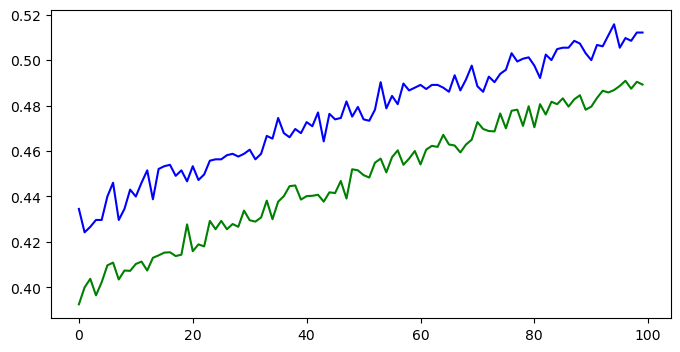

In [28]:
fig = plt.figure(figsize=(8,4))
# plt.plot(history.history['loss'],color='red')
plt.plot(history.history['accuracy'],color='green')
# plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_accuracy'],color='blue')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1229384073549333..1.6597213614402868].


1/1 [==============================] - 0s 15ms/step
Real class: elephant
Predictions:
elephant : 0.08940532
llama : 0.033015434
rhino : 0.027720477
crayfish : 0.025067886
soccer_ball : 0.023419656


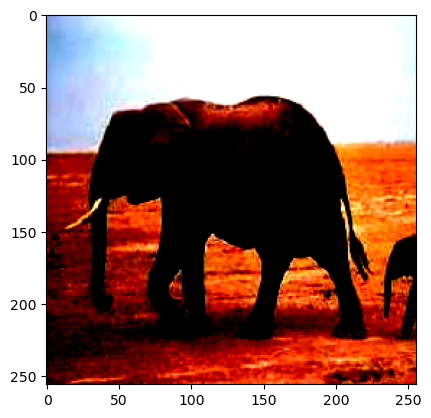

In [40]:
from skimage import io, transform, color, exposure
# Get random image
classnum = np.random.randint(NUMCLASSES)
folder = path + '/' + myclasses[classnum]
filelist = os.listdir(folder)
i = np.random.randint(len(filelist))

while filelist[i].lower()=='thumbs.db':
    i = np.random.randint(len(filelist))

image_path = folder + '/' + filelist[i]
img = io.imread(image_path)

# Prepare image
img = cv2.resize(img,(INPUT_SIZE,INPUT_SIZE))
img = preprocess(img)


plt.imshow(img)
# plt.plot(exposure.histogram(img)[0])
img_tensor = np.expand_dims(img, axis=0)

# Print what the top predicted class is
# print(img_tensor)
preds = model.predict(img_tensor)
preds = preds.flatten()
# print("Output Probabilities:", preds)
order = np.argsort(preds)
order = order[::-1]

reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}
print('Real class:', myclasses[classnum])
print('Predictions:')
for i in range(5):
    if preds[order[i]] == 0:
        break
    else:
        print(reverse_class_labels[order[i]], ':', preds[order[i]])


2025-03-24 10:18:49.194389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - 9s 334ms/step
Real class: Faces_easy	Prediction: lotus
Real class: airplanes	Prediction: chandelier
Real class: airplanes	Prediction: airplanes
Real class: llama	Prediction: helicopter
Real class: Faces_easy	Prediction: ibis
Real class: Motorbikes	Prediction: ketch
Real class: accordion	Prediction: watch
Real class: flamingo	Prediction: Faces_easy
Real class: airplanes	Prediction: cellphone
Real class: Leopards	Prediction: airplanes
Real class: airplanes	Prediction: Leopards
Real class: Faces_easy	Prediction: Leopards
Real class: scissors	Prediction: pizza
Real class: airplanes	Prediction: camera
Real class: brain	Prediction: Motorbikes
Real class: ketch	Prediction: dalmatian
Real class: Motorbikes	Prediction: Motorbikes
Real class: buddha	Prediction: Motorbikes
Real class: gerenuk	Prediction: ketch
Real class: ewer	Prediction: watch
Real class: strawberry	Prediction: Motorbikes
Real class: buddha	Prediction: kangaroo
Real class: lotus	Predictio

array([ 90.,  35., 150.,   9., 159.,   6.,   9.,  14.,  12.,   8.,  10.,
        29.,  17.,   6.,  14.,  15.,   7.,   9.,  23.,  10.,   9.,  13.,
        13.,  10.,  11.,  11.,  10.,  15.,  16.,  16.,  18.,   7.,  12.,
        17.,   9.,  17.,   9.,  10.,  17.,  15.,  13.,   6.,   5.,   7.,
        11.,  14.,  22.,  12.,   8.,  16.,  21.,   7.,  14.,  16.,  24.,
        12.,  18.,  12.,   9.,  15.,  16.,   5.,  12.,   5.,  22.,   7.,
         8.,  11.,   8.,   6.,  13.,   6.,   8.,  14.,  16.,  11.,   7.,
         8.,  16.,  11.,  21.,  13.,   7.,  15.,   7.,  15.,  10.,  13.,
         7.,  15.,  12.,  19.,  22.,  51.,   9.,  19.,   7.,  12.,   5.,
        10.])

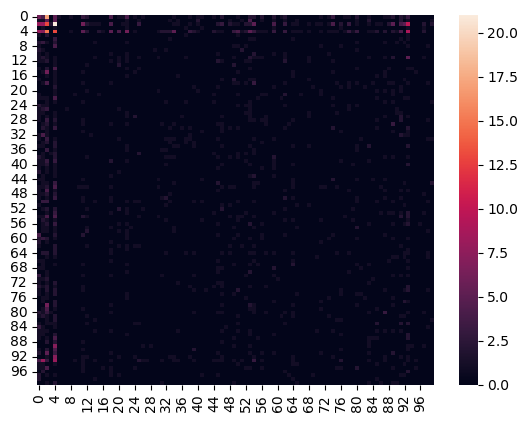

In [30]:
import seaborn as sn

testset = validation_set

predictions = model.predict(testset)

order = np.argsort(predictions)
conf = np.zeros([NUMCLASSES, NUMCLASSES])
count = 0

classcounts = np.zeros(NUMCLASSES)
for i in range(predictions.shape[0]):
    index = order[i,:]
    index = index[::-1]
    print('Real class:', reverse_class_labels[testset.labels[i]], end='\t')
    print('Prediction:',reverse_class_labels[index[0]])
    conf[testset.labels[i],index[0]] += 1
    classcounts[testset.labels[i]]+=1
    if testset.labels[i]==index[0]:
        count+=1
sn.heatmap(conf)
print(count)
classcounts    

<Axes: >

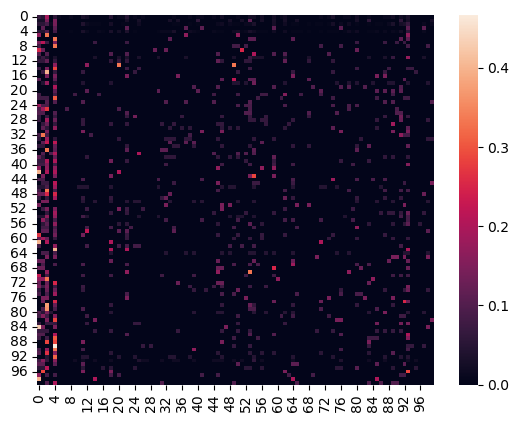

In [32]:
conf2 = np.copy(conf)
for i in range(conf2.shape[0]):
    conf2[i,:] /= classcounts[i]

sn.heatmap(conf2)